In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import collections
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import umap

/zhome/0f/8/221869/miniforge3/envs/text-embeddings/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#Expectes data to be in the same directory as the notebook in a folder called 'data'
#Read in cleaned file after all the preprocessing steps
path_book_ratings = "/zhome/0f/8/221869/compToolsForDs/data/Books_rating_cleaned_new_eng.csv"
br = pd.read_csv(path_book_ratings)

In [8]:
# create random sample of 10000 reviews
br = br.sample(n=1000, random_state=42).reset_index(drop=True)

## Embedding Creation



In [9]:
model = SentenceTransformer('all-MiniLM-L6-v2')
reviews = br['cleanText'].tolist()
embeddings = model.encode(
    reviews,
    batch_size=64,           # tune based on your memory / GPU
    show_progress_bar=True,
    convert_to_numpy=True    # returns a NumPy array
)



Batches: 100%|██████████| 16/16 [00:33<00:00,  2.09s/it]


In [16]:
embeddings.shape

(1000, 384)

## K-means
Todo: 
- try different number of clusters
- Compute average score/score distribution per cluster
- Try different Hyperparameters for UMAP
- Try t-SNE
- Compute score for Clustering

In [18]:
#try clustering the embeddings
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# Fit KMeans on embeddings
labels = kmeans.fit_predict(embeddings)

# labels[i] is the cluster of embeddings[i]
print(labels[:20])  # show the first 20 cluster assignments

# Optional: add cluster labels to your DataFrame if using pandas
import pandas as pd
br["cluster"] = labels

# See cluster counts
print(br["cluster"].value_counts())

[1 4 2 2 1 3 0 2 2 2 4 3 0 4 2 4 0 1 3 4]
cluster
4    271
1    239
2    223
3    175
0     92
Name: count, dtype: int64


/zhome/0f/8/221869/miniforge3/envs/text-embeddings/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


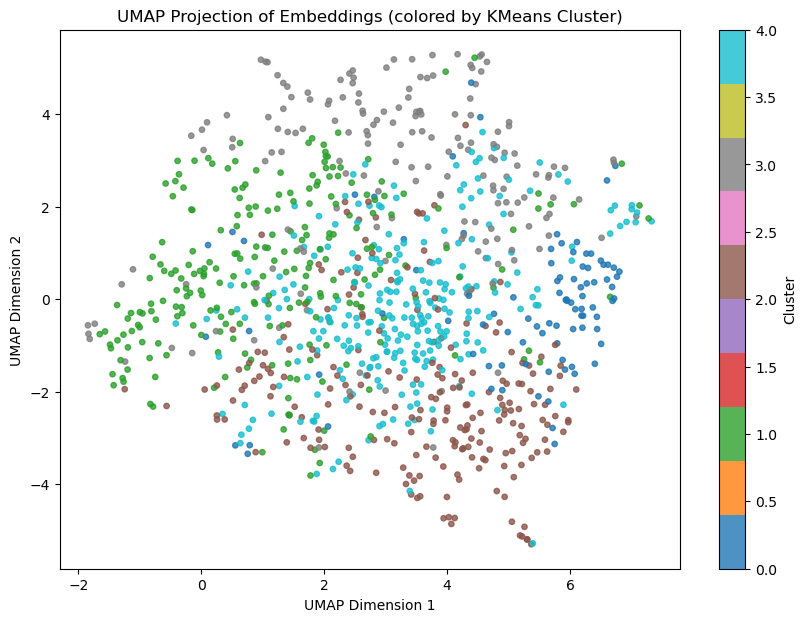

In [25]:
reducer = umap.UMAP(n_neighbors=5, min_dist=0.4, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# --- Visualization ---
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=labels,
    cmap='tab10',  # or 'Spectral', 'viridis', etc.
    s=15,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.title("UMAP Projection of Embeddings (colored by KMeans Cluster)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

/zhome/0f/8/221869/miniforge3/envs/text-embeddings/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


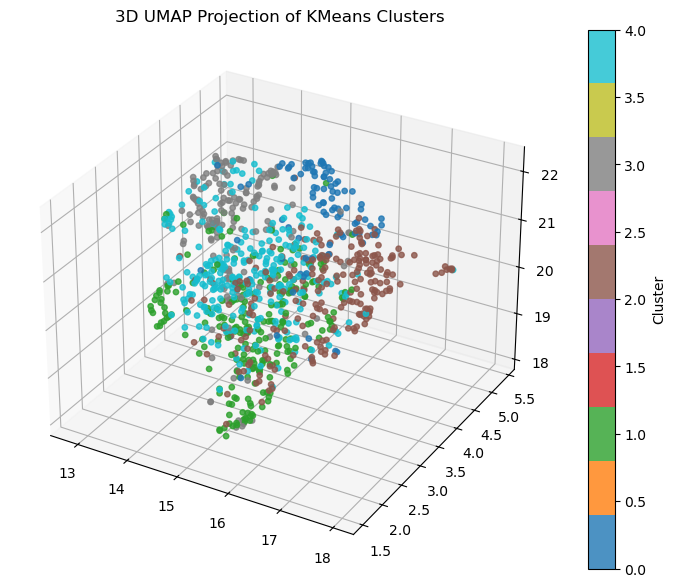

In [26]:
from mpl_toolkits.mplot3d import Axes3D

reducer_3d = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
               c=labels, cmap='tab10', s=15, alpha=0.8)
fig.colorbar(p, label='Cluster')
ax.set_title("3D UMAP Projection of KMeans Clusters")
plt.show()


## DBSCAN